In [1]:
!python -m spacy download fr_core_news_sm

2024-01-22 11:44:31.833028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 11:44:31.833100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 11:44:31.835431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 11:44:31.845372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 11:44:33.799239: W tensorflow/compiler/tf2

In [7]:
import spacy
import pandas as pd
from transformers import BertTokenizer, BertModel
from concurrent.futures import TimeoutError
import multiprocessing as mp

# Load spaCy models
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# Load BERT tokenizer and model for Arabic
tokenizer = BertTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")
model = BertModel.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")

# Define a custom spaCy pipeline component using BERT embeddings
@spacy.Language.component("custom_bert")
def custom_bert_component(doc):
    text = doc.text
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)  # Adjust max_length as needed
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    doc.set_extension("bert_embeddings", default=embeddings, force=True)
    return doc

# Add the custom component to the spaCy pipeline for Darija
nlp_darija = spacy.blank("ar")
nlp_darija.add_pipe("custom_bert", last=True)

# Load your dataset from a CSV file
df = pd.read_csv("songs _data.csv")  # Replace with the actual path to your dataset

# Process lyrics in each language with a timeout
timeout_seconds = 10  # You can adjust the timeout as needed

def process_text(text):
    try:
        return nlp_fr(text) if nlp_fr(text).lang_ == 'fr' else nlp_en(text) if nlp_en(text).lang_ == 'en' else nlp_darija(text)
    except TimeoutError:
        return None

# Use multiprocessing to apply the function with a timeout
with mp.Pool() as pool:
    df['doc'] = pool.map(process_text, df['Lyrics'])

# Access BERT embeddings for each language
df['bert_embeddings'] = df['doc'].apply(lambda x: x._.bert_embeddings if hasattr(x._, 'bert_embeddings') else None)

# Display the processed DataFrame
print(df)


                                                Lyrics  Dialect  \
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...        1   
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا...        1   
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...        1   
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...        1   
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس...        1   
..                                                 ...      ...   
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...        0   
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...        0   
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...        0   
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...        0   
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...        0   

                  Artist                  Song  \
0                    NaN                   NaN   
1                    NaN                   NaN   
2                    NaN                   Na

In [2]:
import spacy
import pandas as pd
from transformers import BertTokenizer, BertModel

# Load spaCy models
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# Load BERT tokenizer and model for Arabic
tokenizer = BertTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")
model = BertModel.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")

# Define a custom spaCy pipeline component using BERT embeddings
@spacy.Language.component("custom_bert")
def custom_bert_component(doc):
    text = doc.text
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)  # Adjust max_length as needed
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    doc.set_extension("bert_embeddings", default=embeddings, force=True)
    return doc

# Add the custom component to the spaCy pipeline for French
nlp_fr.add_pipe("custom_bert", last=True)

# Add the custom component to the spaCy pipeline for English
nlp_en.add_pipe("custom_bert", last=True)

# Add the custom component to the spaCy pipeline for Darija
nlp_darija = spacy.blank("ar")
nlp_darija.add_pipe("custom_bert", last=True)

# Load your dataset from a CSV file
df = pd.read_csv("songs _data.csv")  # Replace with the actual path to your dataset

# Process lyrics in each language
df['doc'] = df['Lyrics'].apply(lambda x: nlp_fr(x) if nlp_fr(x).lang_ == 'fr' else nlp_en(x) if nlp_en(x).lang_ == 'en' else nlp_darija(x))

# Access BERT embeddings for each language
df['bert_embeddings'] = df['doc'].apply(lambda x: x._.bert_embeddings if hasattr(x._, 'bert_embeddings') else None)

# Display the processed DataFrame
print(df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Créez une matrice de similarité vide
similarity_matrix = []

# Parcourez toutes les paires de chansons
for i in range(len(df)):
    similarities = []
    for j in range(len(df)):
        # Mesurez la similarité cosinus entre les embeddings BERT des deux chansons
        similarity = cosine_similarity([df['bert_embeddings'][i]], [df['bert_embeddings'][j]])[0][0]

        # Ajoutez une pondération pour la dialecte (1 si même dialecte, 0 sinon)
        dialect_weight = 1 if df['dialect'][i] == df['dialect'][j] else 0
        weighted_similarity = similarity * dialect_weight
        similarities.append(weighted_similarity)

    similarity_matrix.append(similarities)

# Convertissez la matrice de similarité en DataFrame pour une meilleure lisibilité
similarity_df = pd.DataFrame(similarity_matrix, columns=df.index, index=df.index)

# Affichez la matrice de similarité
print(similarity_df)


     0    1    2    3    4    5    6    7    8    9    ...  982  983  984  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
987  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
988  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
989  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
990  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
991  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   

     985  986  987  988  989  990  991  
0    1.0  1.0  1.0  1.0  1.0  1.0 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


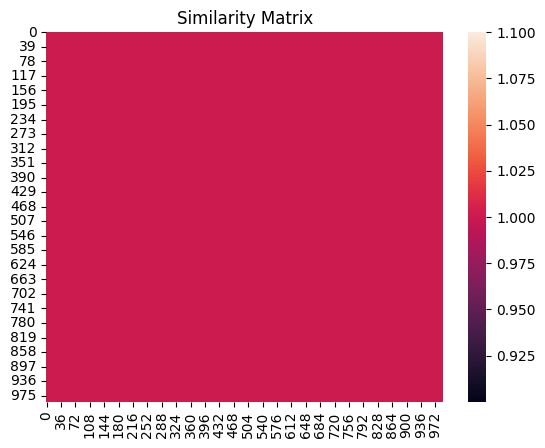

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# Appliquez K-means sur la matrice de similarité
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
num_clusters = 3  # Choisissez le nombre de clusters en fonction de votre analyse
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['dialect'] = kmeans.fit_predict(similarity_matrix)

# Visualisez les clusters
sns.heatmap(similarity_matrix)
plt.title('Similarity Matrix')
plt.show()

# Affichez les chansons dans chaque cluster
for cluster_id in range(num_clusters):
    cluster_songs = df[df['dialect'] == cluster_id].index.tolist()
    print(f'Cluster {cluster_id + 1}: {cluster_songs}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


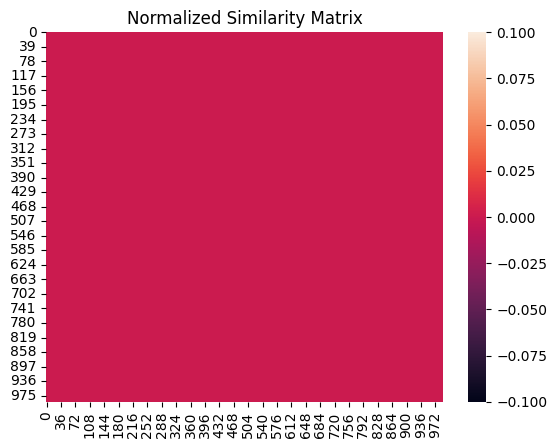

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Normalisez la matrice de similarité
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)

# Appliquez K-means sur la matrice de similarité normalisée
num_clusters = 3  # Choisissez le nombre de clusters en fonction de votre analyse
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['dialect'] = kmeans.fit_predict(normalized_similarity_matrix)

# Visualisez les clusters
sns.heatmap(normalized_similarity_matrix)
plt.title('Normalized Similarity Matrix')
plt.show()

# Affichez les chansons dans chaque cluster
for cluster_id in range(num_clusters):
    cluster_songs = df[df['dialect'] == cluster_id].index.tolist()
    print(f'Cluster {cluster_id + 1}: {cluster_songs}')


In [ ]:
# Choisissez une chanson de référence
reference_song_index = 0

# Triez les chansons en fonction de leur similarité avec la chanson de référence
recommended_songs = similarity_df[reference_song_index].sort_values(ascending=False).index.tolist()

# Affichez les paroles des chansons recommandées
print(f"Chansons recommandées pour la chanson de référence :")
for song_index in recommended_songs[1:6]:  # Exclure la chanson de référence elle-même
    lyrics = df['Lyrics'][song_index]
    print(f"- Chanson {song_index} : {lyrics}")
    print("\n")


Chansons recommandées pour la chanson de référence :
- Chanson 666 : Fe lawl ghaiban draif ou niya ou wld nas 
Wfe lhob ga3ma mwalaf 
Mskin hachoumi w hassas 
Ghatchoufih faris ahlamek ou m3ah 
Hiyatek kemlat w meli ghathali 3ainik 




Ghatel9aaaaih

Kedab ras malo ghir hadra 
Mesehi dmou3ak ou kouni mera
Khoudiha tajriba mora 
Kwiha fe 9albak akheer mara
Akheer mara akheer mara
Akheer mara akheer mara
Akheer mara akheer mara

We bla ib9a fik lhal we tgouli ma3andi zhar 
Ou tkarhi nti ga3 rjal besbab wahed fihom ghdar 
Ghir sabri db iji wld nas li ihazak fo9 ras
We m3ah twali labas ou tensaay

Kedab ras malo ghir hadra 
Mesehi dmou3ak ou kouni mera
Khoudiha tajriba mora 




Kwiha fe 9albak akheer mara
Akheer mara akheer mara
Akheer mara akheer mara
Akheer mara akheer mara

في الأول غا يبان ضريف
و نية و ولد الناس
و فالحب كاعما مولف
مسكين حشومي وحساس

غا أتشوفيه فارس أحلامك
ومعاه حياتك كملات
وملي غا تحلي عينيك غا تلقاي

كداب راس مالو غير هدرة
مسحي دموعك و كوني مرة
خوذيها تجربة مرة
كويه

common themes

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Supposons que 'dialect' dans votre DataFrame représente le pays attribué par K-means
# df est votre DataFrame qui doit contenir une colonne 'lyrics' avec les paroles et une colonne 'dialect' avec les identifiants de pays

# Fonction fictive pour identifier les thèmes communs dans les paroles
def identify_common_themes(lyrics):
    # Utilisez CountVectorizer pour extraire des mots clés des paroles
    vectorizer = CountVectorizer(stop_words='english', max_features=5)
    X = vectorizer.fit_transform(lyrics)
    feature_names = vectorizer.get_feature_names_out()

    # Trouvez les mots clés les plus fréquents
    common_themes = [feature_names[i] for i in X.sum(axis=0).argsort()[0, ::-1]]

    return common_themes

# Affichez les thèmes communs pour chaque pays (dialect)
for country_id in df['dialect'].unique():
    country_songs = df[df['dialect'] == country_id]

    # Affichez les thèmes communs pour le pays (dialect)
    common_themes = identify_common_themes(country_songs['Lyrics'])

    print(f'Thèmes communs pour le pays (dialect) {country_id}: {common_themes}')


Thèmes communs pour le pays (dialect) 0: [array([['la', 'est', 'le', 'les', 'pas']], dtype=object)]


In [ ]:
# Fonction fictive pour identifier les thèmes communs dans les paroles
def identify_common_themes(lyrics):
    vectorizer = CountVectorizer(stop_words='english', max_features=5)
    X = vectorizer.fit_transform(lyrics)
    feature_names = vectorizer.get_feature_names_out()
    common_themes = [feature_names[i] for i in X.sum(axis=0).argsort()[0, ::-1]]
    return common_themes

# Affichez les thèmes communs pour chaque pays (dialect)
for country_id in df['dialect'].unique():
    country_songs = df[df['dialect'] == country_id]

    # Affichez les thèmes communs pour le pays (dialect)
    common_themes = identify_common_themes(country_songs['Lyrics'])
    print(f'Thèmes communs pour le pays (dialect) {country_id}: {common_themes}')

Thèmes communs pour le pays (dialect) 0: [array([['la', 'est', 'le', 'les', 'pas']], dtype=object)]


In [ ]:
!pip install textblob


                                                Lyrics     sentiment
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...  0.000000e+00
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا... -1.200000e-01
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...  4.625929e-17
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...  1.888889e-01
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس... -2.333333e-01
..                                                 ...           ...
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...  0.000000e+00
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...  0.000000e+00
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...  0.000000e+00
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...  0.000000e+00
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...  0.000000e+00

[992 rows x 2 columns]


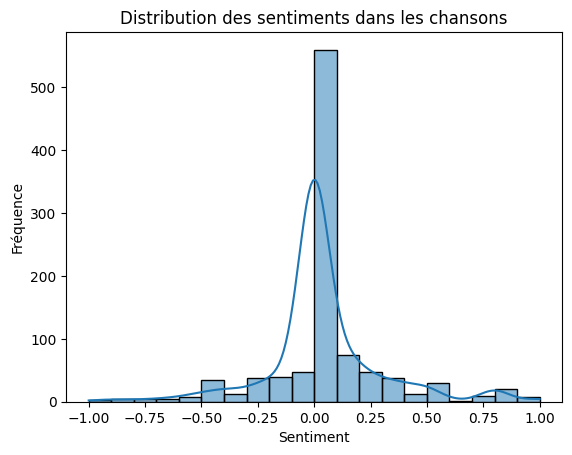

In [ ]:
from textblob import TextBlob

# Ajoutez une nouvelle colonne 'sentiment' à votre DataFrame
df['sentiment'] = df['Lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Affichez les sentiments pour chaque chanson
print(df[['Lyrics', 'sentiment']])

# Visualisez les sentiments communs
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribution des sentiments dans les chansons')
plt.xlabel('Sentiment')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
!pip install nltk


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                Lyrics  sentiment
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...     0.0000
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا...     0.6249
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...     0.9231
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...     0.6908
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس...    -0.5267
..                                                 ...        ...
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...     0.0000
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...     0.0000
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...     0.0000
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...     0.0000
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...     0.0000

[992 rows x 2 columns]


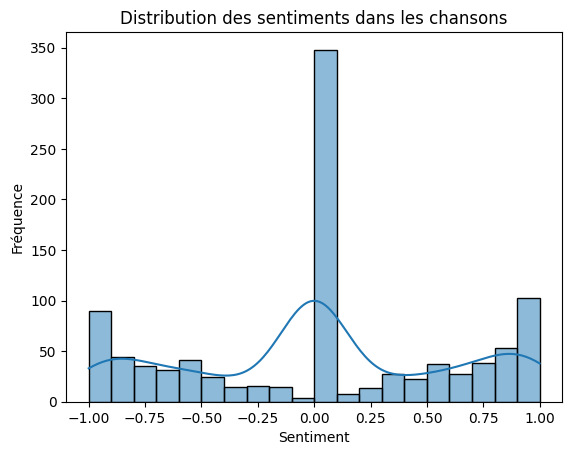

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Téléchargez les ressources nécessaires pour nltk
nltk.download('vader_lexicon')

# Initialisez l'analyseur de sentiment
sia = SentimentIntensityAnalyzer()

# Chargez votre DataFrame à partir du fichier CSV (à remplacer par le chemin réel)
df = pd.read_csv("songs _data.csv")

# Ajoutez une nouvelle colonne 'sentiment' à votre DataFrame
df['sentiment'] = df['Lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Affichez les sentiments pour chaque chanson
print(df[['Lyrics', 'sentiment']])

# Visualisez les sentiments communs
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribution des sentiments dans les chansons')
plt.xlabel('Sentiment')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Load your dataset
df = pd.read_csv('songs _data.csv')

# Preprocess the lyrics
stop_words = set(stopwords.words('english'))  # Add other languages as needed
stemmer = SnowballStemmer('english')  # Use appropriate stemmer for other languages

def preprocess_text(text):
    words = text.lower().split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_lyrics'] = df['Lyrics'].apply(preprocess_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_lyrics'])

# Apply K-means clustering
num_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Explore the clusters
for cluster_id in range(num_clusters):
    cluster_songs = df[df['cluster'] == cluster_id]['lyrics'].tolist()
    print(f'Cluster {cluster_id + 1} Songs:')
    for song in cluster_songs:
        print(song)
    print('\n')
